In [1]:
%pylab inline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read(file):
    with open(file) as f:
        Tl, Tf, DUl, DUf, tl, tf = [], [], [], [], [], []
        for sor in f: # így iterálhatunk végig egy adatfolyamon vagy file-on
            if sor[0]!='%': # file-ban lévő komment kiszedése
                if int(sor.split()[3]) == 14:
                    Tl.append( float(sor.split()[0]) )
                    DUl.append( float(sor.split()[1]) )
                    tl.append( float(sor.split()[2]) )
                elif int(sor.split()[3]) == 10:
                    Tf.append( float(sor.split()[0]) )
                    DUf.append( float(sor.split()[1]) )
                    tf.append( float(sor.split()[2]) )
    #return array(Tl), array(Tf), array(DUl), array(DUf), array(tl), array(tf)
    return array(Tl), array(Tf), array(DUl)*300/1000, array(DUf)*300/1000, array(tl), array(tf)
                                #mV-bn lesz így

def lin(x, a, b):
    return a*x + b

def talppont(x, y, x1):
    popt, pcov = curve_fit(lin, x[(x>x1)], y[(x>x1)]) # az illesztés elvégzése a kijelölt részre
    perr = sqrt(diag(pcov))
    print('egyenes: a, b +- err\n', popt, '+-', perr)
    
    talp = abs(popt[0]*x1 + popt[1]) # negatív, így toljuk felfele
    
    return talp
    
def tol(xl, xf, yl, yf, x1):
    x = array(list(xl) + list(xf))
    y = array(list(yl) + list(yf))
    
    talp_ok = talppont(x, y, x1)
    
    yl = yl + talp_ok
    yf = yf + talp_ok
    
    return yl, yf

def szor(x, y, xp_l, xp_f, name1, name2):
    x_nl = x[x<xp_l]
    y_nl = y[x<xp_l]
    poptp_l, pcovp_l = curve_fit(lin, x_nl, y_nl) # az illesztés elvégzése a kijelölt részre
    perrp_l = sqrt(diag(pcovp_l))
    print('egyenes, lent: a, b +- err\n', poptp_l, '+-', perrp_l)
    
    XP_l = linspace(min(x), xp_l+10, 100)
    plot(x, y, 'bo', markersize = 1, label = 'adatok')
    plot(XP_l, lin(XP_l, *poptp_l), color = 'orange', label = 'fit')
    xlabel('T[K]', fontsize = 15)
    #ylabel(r'$\Delta U [300 \mu V]$', fontsize = 15)
    ylabel(r'$\Delta U$ [mV]', fontsize = 15)
    xlim(min(x), xp_l+10)
    legend()
    plt.tight_layout()
    savefig(name1)
    show()
    
    sigma_l = 0
    for i in range(len(x_nl)):
        if abs(lin(x_nl[i], *poptp_l) - y_nl[i]) > sigma_l:
            sigma_l = abs(lin(x_nl[i], *poptp_l) - y_nl[i])
                   
    x_nf = x[x>xp_f]
    y_nf = y[x>xp_f]
    poptp_f, pcovp_f = curve_fit(lin, x_nf, y_nf) # az illesztés elvégzése a kijelölt részre
    perrp_f = sqrt(diag(pcovp_f))
    print('egyenes, fent: a, b +- err\n', poptp_f, '+-', perrp_f)

    XP_f = linspace(xp_f, max(x), 100)
    plot(x, y, 'bo', markersize = 1, label = 'adatok')
    plot(XP_f, lin(XP_f, *poptp_f), color = 'orange', label = 'fit')
    xlabel('T[K]', fontsize = 15)
    #ylabel(r'$\Delta U [300 \mu V]$', fontsize = 15)
    ylabel(r'$\Delta U$ [mV]', fontsize = 15)
    xlim(xp_f,)
    legend()
    plt.tight_layout()
    savefig(name2)
    show()
    
    sigma_f = 0
    for j in range(len(x_nf)):
        if abs(lin(x_nf[j], *poptp_f) - y_nf[j]) > sigma_f:
            sigma_f = abs(lin(x_nf[j], *poptp_f) - y_nf[j])
    
    return max([sigma_l, sigma_f])

def sebill(x, y, y1, y2):
    popt, pcov = curve_fit(lin, x[(y>y1)*(y<y2)], y[(y>y1)*(y<y2)]) # az illesztés elvégzése a kijelölt részre
    perr = sqrt(diag(pcov))
    print('egyenes: a, b +- err\n', popt, '+-', perr)
    
    return popt, perr

def seb(xl, xf, yl, yf, y1, y2):
    print('le\n')
    paraml, paraml_err = sebill(xl, yl, y1, y2)
    print('fel\n')
    paramf, paramf_err = sebill(xf, yf, y1, y2)
    
    XL = linspace(min(xl[(yl>y1)*(yl<y2)]), max(xl[(yl>y1)*(yl<y2)]), 100)
    XF = linspace(min(xf[(yf>y1)*(yf<y2)]), max(xf[(yf>y1)*(yf<y2)]), 100)
    plot(xl, yl, 'bo', markersize = 1, label = 'hűtés')
    plot(XL, lin(XL, *paraml), color = 'orange', label = 'hűtés fit')
    plot(xf, yf, 'rs', markersize = 1, label = 'melegítés')
    plot(XF, lin(XF, *paramf), color = 'green', label = 'melegítés fit')
    ylim(y1, y2)
    xlabel('t[s]', fontsize = 15)
    ylabel('T[K]', fontsize = 15)
    legend()
    plt.tight_layout()
    savefig('seb.png')
    
    return paraml, paramf

def tav(xl, xf, yl, yf, place):
    i_l = interp1d(yl, xl) #így du értékei alapján lehet nézni a szélességet
    i_f = interp1d(yf, xf)
    
    D = []
    for i in range(len(place)):
        D.append(abs(float(i_f(place[i]) - i_l(place[i]))))
    D_err = 0
    for j in range(len(D)):
        if abs(D[j] - mean(D)) > D_err:
            D_err = abs(D[j] - mean(D))
            
    print('d =', mean(D), '+-', D_err, 'K')
    
    return mean(D), D_err

    
def atlag(xl, xf, yl, yf, place):
    #interpoláció!! vagy átlagos távolság
    d, d_err = tav(xl, xf, yl, yf, place)
    xl_t = xl + d/2
    xf_t = xf - d/2
    
    return xl_t, xf_t
    
    
def sulyatl(xl, xf, yl, yf, place, vl, vf):
    #talán itt is interpolció vagy átlagos távolság
    #T-t grafikon a hiszterézis résznél kb lin --> illesztés és meredekség --> súlyozűs az átlagban
    d, d_err = tav(xl, xf, yl, yf, place)
    
    dl = d * vl / (vl+vf)
    df = d * vf / (vl+vf)
    
    xl_t = xl + dl
    xf_t = xf - df
    
    return xl_t, xf_t

def temps(x, y, xF):
    k = interp1d(x, y)
    i_k = interp1d(y, x)
    k_c = min(y) + (float(k(xF) - k(x[list(y).index(min(y))])) / 2) #Tc-hez tartozó khí
    #k_c = k(xF) - (float(k(xF) - k(xD)) / 2) #Tc-hez tartozó khí
    T_c = float(i_k(k_c))
    
    k_tl = min(y) * 0.9 #khi 90%-a
    #k_tl = float(k(xD)) * 0.9 #khi 90%-a
    T_tl = float(i_k(k_tl))
    k_tf = min(y) * 0.1 #khi 90%-a
    #k_tf = float(k(xD)) * 0.1 #khi 90%-a
    T_tf = float(i_k(k_tf))
    
    T_w = abs(T_tf - T_tl)
    #hiba? --> eltolásból leginkább, hiszterézis szélessége pl.
    
    return T_c, T_w

In [3]:
Tle, Tfel, dule, dufel, tle, tfel = read('2020_tavasz.dat')

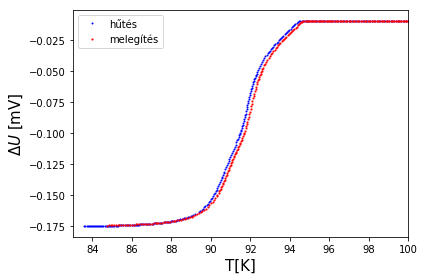

In [4]:
plot(Tle, dule, 'bo', markersize = 1, label = 'hűtés')
plot(Tfel, dufel, 'rs', markersize = 1, label = 'melegítés')
xlim(83, 100)
xlabel('T[K]', fontsize = 15)
#ylabel(r'$\Delta U [300 \mu V]$', fontsize = 15)
ylabel(r'$\Delta U$ [mV]', fontsize = 15)
legend()
plt.tight_layout()
savefig('hiszt.png')

In [5]:
dule, dufel = tol(Tle, Tfel, dule, dufel, 94.9)

egyenes: a, b +- err
 [ 1.76594284e-05 -1.14748384e-02] +- [5.25318941e-07 5.32165103e-05]


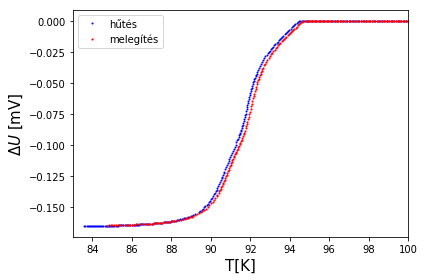

In [6]:
plot(Tle, dule, 'bo', markersize = 1, label = 'hűtés')
plot(Tfel, dufel, 'rs', markersize = 1, label = 'melegítés')
xlim(83, 100)
xlabel('T[K]', fontsize = 15)
#ylabel(r'$\Delta U [300 \mu V]$', fontsize = 15)
ylabel(r'$\Delta U$ [mV]', fontsize = 15)
legend()
plt.tight_layout()
savefig('hiszt_tol.png')

le

egyenes: a, b +- err
 [-1.95822442e-02  1.24830445e+02] +- [1.51333710e-04 2.54461671e-01]
fel

egyenes: a, b +- err
 [ 0.02505035 16.12162072] +- [7.63524450e-05 2.31392908e-01]


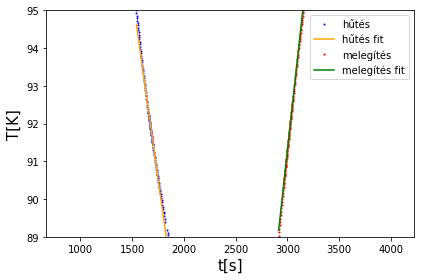

In [7]:
vp_le, vp_fel = seb(tle, tfel, Tle, Tfel, 89, 95)

In [8]:
hely = [-0.13, -0.1, -0.076, -0.042, -0.018]

In [9]:
Tle_a, Tfel_a = atlag(Tle, Tfel, dule, dufel, hely)

d = 0.1940773613061168 +- 0.014814258025057814 K


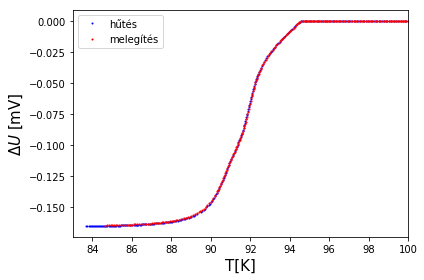

In [10]:
plot(Tle_a, dule, 'bo', markersize = 1, label = 'hűtés')
plot(Tfel_a, dufel, 'rs', markersize = 1, label = 'melegítés')
xlim(83, 100)
xlabel('T[K]', fontsize = 15)
#ylabel(r'$\Delta U [300 \mu V]$', fontsize = 15)
ylabel(r'$\Delta U$ [mV]', fontsize = 15)
legend()
plt.tight_layout()
savefig('tol_atlag.png')

In [11]:
Tle_s, Tfel_s = sulyatl(Tle, Tfel, dule, dufel, hely, abs(vp_le[0]), abs(vp_fel[0]))

d = 0.1940773613061168 +- 0.014814258025057814 K


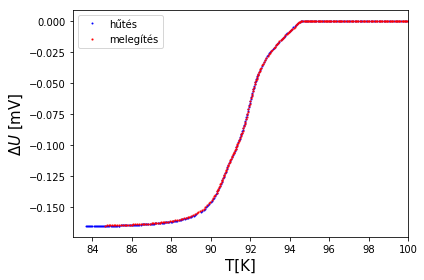

In [12]:
plot(Tle_s, dule, 'bo', markersize = 1, label = 'hűtés')
plot(Tfel_s, dufel, 'rs', markersize = 1, label = 'melegítés')
xlim(83, 100)
xlabel('T[K]', fontsize = 15)
#ylabel(r'$\Delta U [300 \mu V]$', fontsize = 15)
ylabel(r'$\Delta U$ [mV]', fontsize = 15)
legend()
plt.tight_layout()
savefig('tol_suly.png')

In [13]:
T_a = array(list(Tle_a) + list(Tfel_a))
T_s = array(list(Tle_s) + list(Tfel_s))
du = array(list(dule) + list(dufel))

egyenes, lent: a, b +- err
 [ 0.00087163 -0.23877051] +- [2.35474507e-05 2.02454420e-03]


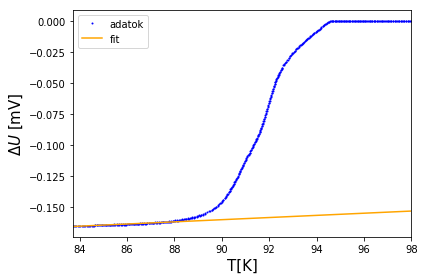

egyenes, fent: a, b +- err
 [ 1.77907370e-05 -1.68888973e-03] +- [5.18190007e-07 5.25207905e-05]


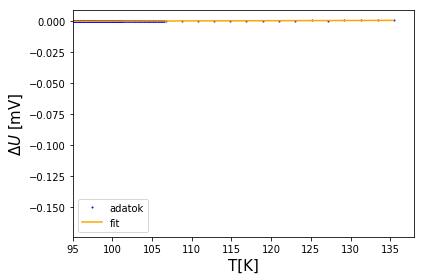

egyenes, lent: a, b +- err
 [ 0.00087163 -0.23876015] +- [2.35474496e-05 2.02426420e-03]


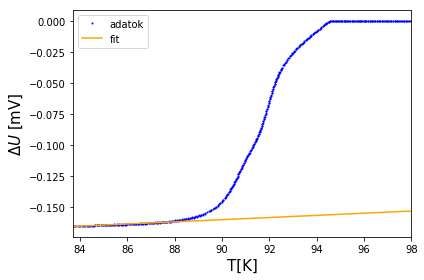

egyenes, fent: a, b +- err
 [ 1.77907370e-05 -1.68867823e-03] +- [5.18190013e-07 5.25146414e-05]


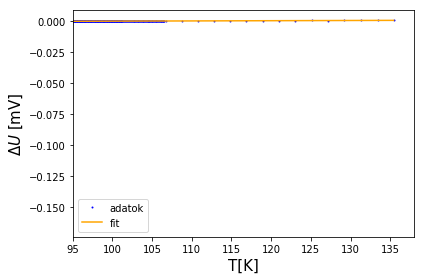

duszórása, átlagolásnál: 0.0009101305048738739
duszórása, súyozásnál: 0.0009101305491798217


In [14]:
du_err_a = szor(T_a, du, 88, 95, 'plat_l_atl.png', 'plat_f_atl.png')
du_err_s = szor(T_s, du, 88, 95, 'plat_l_suly.png', 'plat_f_suly.png')
print('duszórása, átlagolásnál:', du_err_a)
print('duszórása, súyozásnál:', du_err_s)

In [15]:
u0 = 6.92 #mV
u0_err = 0.01
Vm = 22
V = 300

In [16]:
khi = -1 * (abs(du)/u0) * (V/Vm)
khi_err_a = (abs(du_err_a/u0) + abs(u0_err * du/u0**2)) * (V/Vm)
khi_err_s = (abs(du_err_s/u0) + abs(u0_err * du/u0**2)) * (V/Vm)

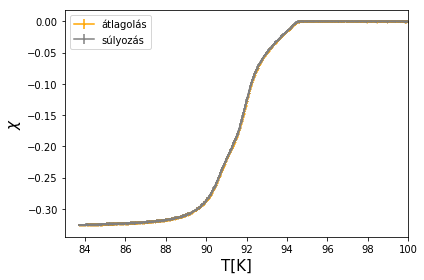

In [17]:
errorbar(T_a, khi, yerr = khi_err_a, color = 'orange', marker = '+', markersize = 1, label = 'átlagolás')
errorbar(T_s, khi, yerr = khi_err_s, color = 'gray', marker = '.', markersize = 1, label = 'súlyozás')
xlim(83, 100)
xlabel('T[K]', fontsize = 15)
ylabel(r'$\chi$', fontsize = 15)
legend()
plt.tight_layout()
savefig('szuszc.png')

In [18]:
min(khi)

-0.32588282580603056

In [19]:
khi_err_a[list(khi).index(min(khi))]

0.002264407338015561

In [20]:
khi_err_s[list(khi).index(min(khi))]

0.0022644074253236547

(83, 90)

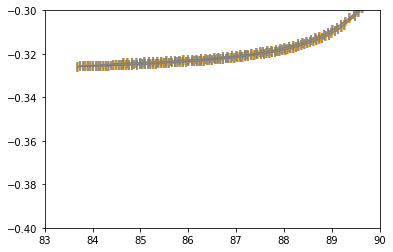

In [21]:
errorbar(T_a, khi, yerr = khi_err_a, color = 'orange', marker = '+', markersize = 1, label = 'átlagolás')
errorbar(T_s, khi, yerr = khi_err_s, color = 'gray', marker = '.', markersize = 1, label = 'súlyozás')
ylim(-0.4, -0.3)
xlim(83, 90)

In [22]:
Tc_a, Tw_a = temps(T_a, khi, 95)
print('Tc_atl =', Tc_a, 'K')
print('Tw_atl =', Tw_a, 'K')
Tc_s, Tw_s = temps(T_s, khi, 95)
print('Tc_suly =', Tc_s, 'K')
print('Tw_suly =', Tw_s, 'K')
print('+- d = 0.19415072839347544 +- 0.014660561856297244 K')

Tc_atl = 91.72489365777624 K
Tw_atl = 3.650953672598618 K
Tc_suly = 91.71308103522335 K
Tw_suly = 3.650953672598618 K
+- d = 0.19415072839347544 +- 0.014660561856297244 K


In [23]:
0.19415072839347544/2

0.09707536419673772